### __BBC News Text Classification__

In [1]:
import plaidml.keras
plaidml.keras.install_backend()
import os
os.environ["KERAS_BACKEND"]="plaidml.keras.backend"

In [2]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
#download bbc text from web
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv \
    -O /tmp/bbc-text.csv

--2021-03-27 15:51:36--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 2607:f8b0:4023:1006::80, 2607:f8b0:4023:1000::80, 142.250.138.128
Connecting to storage.googleapis.com (storage.googleapis.com)|2607:f8b0:4023:1006::80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [application/octet-stream]
Saving to: ‘/tmp/bbc-text.csv’

/tmp/bbc-text.csv   100%[===================>]   4.82M  11.8MB/s    in 0.4s    

2021-03-27 15:51:37 (11.8 MB/s) - ‘/tmp/bbc-text.csv’ saved [5057493/5057493]



In [4]:
#define hyperparams
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<oov>'
training_portion = 0.8

In [5]:
#define stop words and create lists
sentences = []
labels = []
stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
print(len(stopwords))

153


In [6]:
import pandas as pd
dat = pd.read_csv('/tmp/bbc-text.csv')
dat.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [7]:
#read data, split tokens, obtain sentences and labels
#check length of labels, sentences and print the first sentence
with open("/tmp/bbc-text.csv", 'r') as csvfile:
    csv_reader = csv.reader(csvfile, delimiter=',')
    next(csv_reader, None)
    
    for row in csv_reader:
        labels.append(row[0])
        sentence = row[1]
        
        for word in stopwords:
            token = ' ' + word + ' '
            sentence = sentence.replace(token, ' ').replace(' ', ' ')
            
        sentences.append(sentence)
        
print(len(labels))
print(len(sentences))
print(len(sentences[0]))

2225
2225
3123


In [8]:
#split data into train:test
train_size = int(len(sentences)* training_portion)

train_sentences = sentences[:train_size]
train_labels = labels[:train_size]

validation_sentences = sentences[train_size:]
validation_labels = labels[train_size:]

print(train_size)
print(len(train_sentences))
print(len(train_labels))
print(len(validation_sentences))
print(len(validation_labels))

1780
1780
1780
445
445


In [9]:
#tokenize words, fit on text, set sequences and padding for training sets
tokenizer = Tokenizer(
    num_words=vocab_size,
    oov_token=oov_tok
)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)

train_padded = pad_sequences(
    train_sequences,
    padding=padding_type,
    maxlen=max_length
)

print(len(train_sequences[0]))
print(len(train_padded[0]))

449
120


In [10]:
#define validation sets

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(
    validation_sequences,
    padding=padding_type,
    maxlen=max_length
)

print(len(validation_sequences))
print(validation_padded.shape)

445
(445, 120)


In [11]:
#tokenize validation sets, create numpy arrays for training and validation sets

label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

In [12]:
#build model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

#compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           16000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 150       
Total params: 16,558
Trainable params: 16,558
Non-trainable params: 0
_________________________________________________________________


In [13]:
#train model with history
epochs = 30
history = model.fit(
    train_padded,
    training_label_seq,
    epochs=epochs,
    validation_data=(validation_padded, validation_label_seq),
    verbose=2
)

Epoch 1/30
56/56 - 0s - loss: 1.7745 - accuracy: 0.2270 - val_loss: 1.7488 - val_accuracy: 0.2315
Epoch 2/30
56/56 - 0s - loss: 1.7107 - accuracy: 0.2871 - val_loss: 1.6619 - val_accuracy: 0.4382
Epoch 3/30
56/56 - 0s - loss: 1.5931 - accuracy: 0.5180 - val_loss: 1.5090 - val_accuracy: 0.6180
Epoch 4/30
56/56 - 0s - loss: 1.4066 - accuracy: 0.6090 - val_loss: 1.3088 - val_accuracy: 0.6157
Epoch 5/30
56/56 - 0s - loss: 1.1877 - accuracy: 0.6438 - val_loss: 1.1094 - val_accuracy: 0.6629
Epoch 6/30
56/56 - 0s - loss: 0.9820 - accuracy: 0.7601 - val_loss: 0.9205 - val_accuracy: 0.8090
Epoch 7/30
56/56 - 0s - loss: 0.7915 - accuracy: 0.8742 - val_loss: 0.7544 - val_accuracy: 0.8697
Epoch 8/30
56/56 - 0s - loss: 0.6267 - accuracy: 0.9124 - val_loss: 0.6159 - val_accuracy: 0.8989
Epoch 9/30
56/56 - 0s - loss: 0.4948 - accuracy: 0.9371 - val_loss: 0.5111 - val_accuracy: 0.8966
Epoch 10/30
56/56 - 0s - loss: 0.3920 - accuracy: 0.9455 - val_loss: 0.4307 - val_accuracy: 0.9056
Epoch 11/30
56/56 -

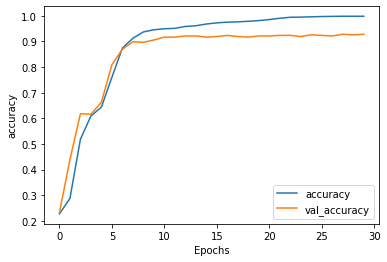

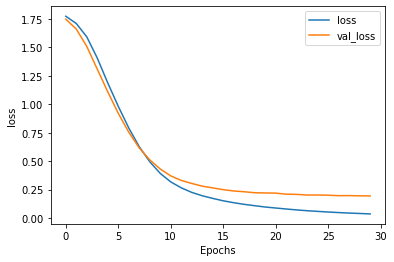

In [14]:
#plot performance
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")